In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
from numba import njit
from functools import lru_cache

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [3]:
plt.style.use('seaborn-whitegrid')
rcParams['font.size'] = 18
rcParams['figure.figsize'] = (12, 8)

In [4]:
digits, digit_class = load_digits(return_X_y=True)
rand_idx = np.random.choice(np.arange(digits.shape[0]), size=500, replace=False)
data = digits[rand_idx,:].copy()
classes = digit_class[rand_idx]

In [5]:
def pairwise_dist_mat(X):
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return D

In [6]:
dist_mat = pairwise_dist_mat(data)

In [7]:

def distance_pair(i, j):
    return dist_mat[i,j]
    

def distance_all(i):
    return np.delete(dist_mat[i,:], i, axis=0)



def entropy(asym_affinities, eps=1e-12):
    """
    Shannon entropy of pairwise affinity
    """
    asym_affinities = np.clip(asym_affinities, eps, None) # Some are so small that log2 fails.
    return - np.sum(asym_affinities * np.log2(asym_affinities))


def perplexity(asym_affinities):
    return 2**entropy(asym_affinities)


def get_pairwise_affinities(i, X, perp, tol):
    """
    Returns sigma and pji affinities for a specific value of i which
    corresponds to perp, the desired perplexity.
    
    Output Shape: Sigma is scalar, pji is 1xm asym affinities
    """
    #sigma, i_asym_affinities = - np.inf, np.zeros(X.shape[0])
    
    # Element-wise min and max, the "corners" of the diagonal of an enclosing orthotope around the data.
    x_min = np.min(X, axis=0)
    x_max = np.max(X, axis=0)

    sigma_max = 1e12
    sigma_min = 1e-12
    attempts = 50
    current_perp = np.inf
    
    while abs(current_perp - perp) > tol and attempts>0:
        sigma = (sigma_min + sigma_max) / 2
        i_asym_affinities = row_pairwise_affinities(i, X, sigma)
        current_perp = perplexity(i_asym_affinities)
        attempts-=1
        if current_perp == perp:
            break
        if current_perp > perp:
            sigma_max = sigma
        elif current_perp < perp:
            sigma_min = sigma
        
    return sigma, i_asym_affinities
    
def row_pairwise_affinities(i, X, sigma_i):
    """
    Calculate the entire conditional distribution P_{j|i} for all j,
    for a specified i and sigma.
    
    Output shape: 1xm, 0 at i == j.
    """
    asym_affinities = np.empty(X.shape[0], dtype=np.float64)
    for j in range(X.shape[0]):
        asym_affinities[j] = pairwise_affinity(i, j, X, sigma_i)
        
    return asym_affinities
    

    
def all_pairwise_sym_affinities(X, perp, tol):
    """
    Calculate the entire symmetric distribution P for a specified and sigmas.
    TODO: takes a while
    Output shape: mxm.
    """
    m, n = X.shape
    pairwise_affin_mat = np.zeros((m,m))
    for i  in tqdm(range(m), "sym affinity"):
        _, pairwise_affin_mat[i,:] = get_pairwise_affinities(i, X, perp, tol)
        pass
    
    sym_affinities = (pairwise_affin_mat + pairwise_affin_mat.T)/(2*m)
    
    return sym_affinities



def pairwise_affinity(i, j, X, sigma_i):
    """
    Returns asymmetric affinity, p_{j|i}
    
    Output Shape: scalar
    """
    # eq 1
    if i == j: # Shortcut
        return 0
    xi = X[i,:]
    xj = X[j,:]
    numer = np.exp((-distance_pair(i,j))/(2*(sigma_i**2)))
    denom = np.exp(-distance_all(i)/(2 * sigma_i ** 2))
    denom = np.sum(denom)
    pji = (numer)/(denom)
    return pji


def low_dimensional_affinity_denom(Y):
    denom = 0
    for k in range(Y.shape[0]):
        denom += np.sum([(1 + np.linalg.norm(Y[k,:] - np.delete(Y, k, axis=0), axis=1)**2) ** (-1)])
        pass
    return denom

def low_dimensional_affinity(i, j, Y, q_denom):
    """
    Returns low dimensional affinity, q_{ij}
    
    Output Shape: scalar
    """
    # eq 4
    yi = Y[i,:]
    yj = Y[j,:]
    
    numer = (1 + np.linalg.norm(yi - yj)**2) ** (-1)
    qij = numer/q_denom
    return qij


def all_low_dimensional_affinities(Y):
    """
    Calculate the entire low dimensional affinity Q
    
    Output shape: mxm.
    """
    m = Y.shape[0]
    low_dim_affinities = np.zeros((m, m))
    q_denom = low_dimensional_affinity_denom(Y)
    for i in range(m):
        for j in range(i+1):
            low_dim_affinities[i, j] = low_dimensional_affinity(i, j, Y, q_denom)
        
    return low_dim_affinities


def compute_partial(i, P, Q, Y):
    # eq 5
    m,n = Y.shape
    partial = np.zeros(n)
    # TODO: vectorize
    for j in range(m):
        partial+=(P[i,j] - Q[i,j]) * (Y[i,:] - Y[j,:]) * (1 + np.linalg.norm(Y[i,:] - Y[j,:])**2)**(-1)
    
    return 4*partial


def compute_grad(P, Q, Y):
    # eq 5
    m = Y.shape[0]
    grad = np.zeros_like(Y)
    for i in range(m):
        grad[i,:] = compute_partial(i, P, Q, Y)
    return grad

In [8]:
def momentum_func(t):
    if t< 250:
        return .5
    else:
        return .8

    
def tsne(data, n_components, perp, n_iter, lr, momentum, perp_tol=1e-2):
    P = all_pairwise_sym_affinities(data, perp, perp_tol)
#     P = P/np.sum(P)
    P = np.clip(P, 1e-12, None)
    init_mean = np.zeros(n_components)
    init_cov = np.identity(n_components) * 1e-4
    
    Y = np.random.multivariate_normal(mean=init_mean, cov=init_cov, size=data.shape[0])

    Y_old = np.zeros_like(Y)

    costs = []
    for t in tqdm(range(n_iter), "iterations"):
        Q = all_low_dimensional_affinities(Y)
#         Q = num/np.sum(num)
        Q = np.clip(Q, 1e-12, None)
        
        grad = compute_grad(P, Q, Y)

        Y = Y - lr*grad #+ momentum(t)*(Y - Y_old)

        C = np.sum(P * np.log(P / Q))
        costs.append(C)
        Y_old = Y.copy()

        if t %50 == 0 or t == (n_iter-1):
            print(f'cost at {t}: ', C)
        pass
    return costs, Y

In [9]:
perp_tol = 1e-8
n_components = 2
perp = 30
n_iter = 500
lr = 100
momentum = momentum_func

In [10]:
costs, results = tsne(data, n_components, perp, n_iter, lr, momentum, perp_tol=1e-5)

cost at 0:  10.329347533608749
cost at 50:  9.703516037182444
cost at 100:  9.539565365531459
cost at 150:  9.476395931866076
cost at 200:  9.441868571897896
cost at 250:  9.420099622774309
cost at 300:  9.40506506126958
cost at 350:  9.39387327720026
cost at 400:  9.385256824425916
cost at 450:  9.379398982815369
cost at 499:  9.374758813357813



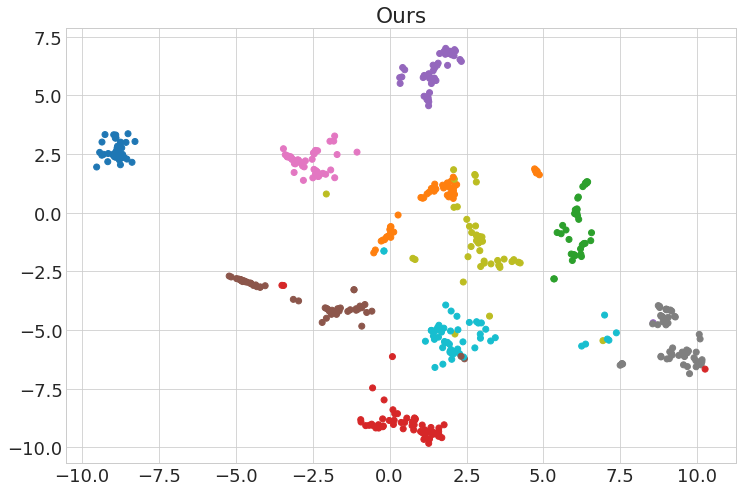

In [11]:
plt.scatter(results[:,0],results[:,1], c=classes, cmap='tab10')
plt.title('Ours')
plt.show()

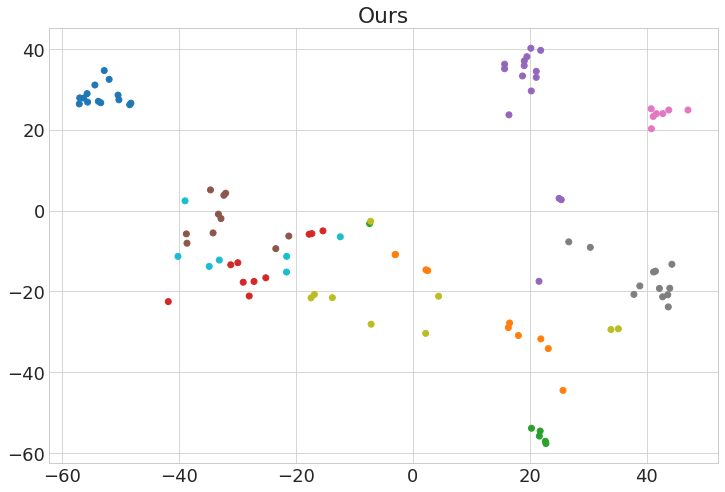

In [24]:
plt.scatter(results[:,0],results[:,1], c=classes, cmap='tab10')
plt.title('Ours')
plt.show()

In [15]:
tsne = TSNE(n_components=2,
            n_iter=n_iter,
            random_state=42,
            perplexity=perp,
            n_jobs=-1)

tsne_digits = tsne.fit_transform(data)

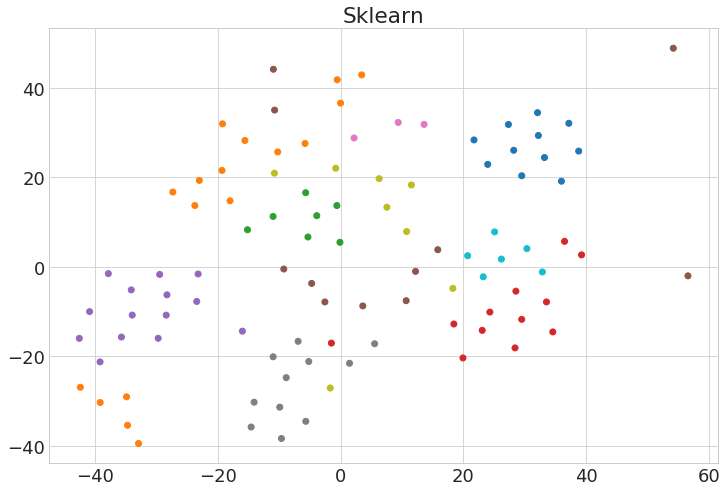

In [16]:
plt.scatter(tsne_digits[:,0],tsne_digits[:,1], c=classes, cmap='tab10')
plt.title('Sklearn')
plt.show()